In [27]:
import os
import numpy as np
import pandas as pd
import joblib, os, pickle, torch
import pefile
import ember
import torch
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
# from torch.nn.functional import sigmoid
# from features import PEFeatureExtractor


# Model Def

In [3]:
class MalConvPlus(nn.Module):
    def __init__(self, embed_dim, max_len, out_channels, window_size, dropout=0.5):
        super(MalConvPlus, self).__init__()
        self.tok_embed = nn.Embedding(257, embed_dim)
        self.pos_embed = nn.Embedding(max_len, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels * 2,
            kernel_size=window_size,
            stride=window_size,
        )
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        tok_embedding = self.tok_embed(x)
        pos = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1).to(x.device)
        pos_embedding = self.pos_embed(pos)
        embedding = self.dropout(tok_embedding + pos_embedding)
        conv_in = embedding.permute(0, 2, 1)
        conv_out = self.conv(conv_in)
        glu_out = F.glu(conv_out, dim=1)
        values, _ = glu_out.max(dim=-1)
        output = self.fc(values).squeeze(1)
        return output

class AttentionRCNN(nn.Module):
    def __init__(
        self,
        embed_dim,
        out_channels,
        window_size,
        module,
        hidden_size,
        num_layers,
        bidirectional,
        attn_size,
        residual,
        dropout=0.5,
    ):
        super(AttentionRCNN, self).__init__()
        assert module.__name__ in {
            "RNN",
            "GRU",
            "LSTM",
        }, "`module` must be a `torch.nn` recurrent layer"
        self.residual = residual
        self.embed = nn.Embedding(257, embed_dim)
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels,
            kernel_size=window_size,
            stride=window_size,
        )
        self.rnn = module(
            input_size=out_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
        )
        rnn_out_size = (int(bidirectional) + 1) * hidden_size
        self.local2attn = nn.Linear(rnn_out_size, attn_size)
        self.global2attn = nn.Linear(rnn_out_size, attn_size, bias=False)
        self.attn_scale = nn.Parameter(
            nn.init.kaiming_uniform_(torch.empty(attn_size, 1))
        )
        self.dropout = nn.Dropout(dropout)
        if residual:
            self.fc = nn.Linear(out_channels + rnn_out_size, 1)
        else:
            self.fc = nn.Linear(rnn_out_size, 1)

    def forward(self, x):
        embedding = self.dropout(self.embed(x))
        conv_in = embedding.permute(0, 2, 1)
        conv_out = self.conv(conv_in)
        if self.residual:
            values, _ = conv_out.max(dim=-1)
        conv_out = conv_out.permute(2, 0, 1)
        rnn_out, _ = self.rnn(conv_out)
        global_rnn_out = rnn_out.mean(dim=0)
        attention = torch.tanh(
            self.local2attn(rnn_out) + self.global2attn(global_rnn_out)
        ).permute(1, 0, 2)
        alpha = F.softmax(attention.matmul(self.attn_scale), dim=-1)
        rnn_out = rnn_out.permute(1, 0, 2)
        fc_in = (alpha * rnn_out).sum(dim=1)
        if self.residual:
            fc_in = torch.cat((fc_in, values), dim=-1)
        output = self.fc(fc_in).squeeze(1)
        return output

In [4]:
def extract_features(data):
    extractor = ember.PEFeatureExtractor(2)
    # temp = extractor.feature_vector(data)
    # print(temp)
    features = np.array(extractor.feature_vector(data), dtype=np.float32)
    pe = pefile.PE(data=data)
    return [features], list(pe.header)


In [6]:
test = r"../test/datasets/gw3/0007"
with open(test, "rb") as f:
    data = f.read()
features_data, header = extract_features(data)

# Test Models

## RF 1

In [5]:
clf = joblib.load("../models/rf_ember_subset.joblib")
# features = pickle.load(open("../models/features.pkl", "rb"))
clf.predict_proba(features_data)
# pe_features = np.array([features_data[feature] for feature in features])
# y_pred = clf.predict_proba([pe_features])
# predictions.append(int(prediction1[0]))

/scratch/user/chan0305/.conda/envs/ember/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/scratch/user/chan0305/.conda/envs/ember/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


array([[0.28810592, 0.71189408]])

## Malconv

In [7]:
# Load Malconv Model
embed_dim = 8
max_len = 4096
out_channels = 128
window_size = 32
dropout = 0.5
weight_path = "../models/malconv_v2.pt"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model = MalConvPlus(embed_dim, max_len, out_channels, window_size, dropout)
model.load_state_dict(torch.load(weight_path))
model.to(device)
model.eval()
input = torch.tensor(header).unsqueeze(0).to(device)
y_pred2 = torch.sigmoid(model(input))



/home/kenchan/anaconda3/envs/ember/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


## AttnRNN

In [9]:
# Load AttnRNN Model
embed_dim = 8
max_len = 4096
out_channels = 128
window_size = 32
module = torch.nn.RNN
hidden_size = 128
num_layers = 8
bidirectional = True
attn_size = 128
residual = True
dropout = 0.5
weight_path = "../models/attn_custom_v0.pt"
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")
device = torch.device("cpu")
model = AttentionRCNN(embed_dim, out_channels, window_size, module, hidden_size, num_layers, bidirectional, attn_size, residual, dropout).to(device)
model.load_state_dict(torch.load(weight_path))
model.to(device)
model.eval()
input = torch.tensor(header).unsqueeze(0).to(device)
y_pred3 = torch.sigmoid(model(input))
y_pred3

tensor([0.4687], grad_fn=<SigmoidBackward0>)

# Inference

## Load Models

In [7]:
from tqdm import tqdm
# load RF models
clf = joblib.load("../models/rf_ember_subset.joblib")
# bodmas_clf = joblib.load("../models/bodmas/model.joblib")
# features = pickle.load(open("../models/features.pkl", "rb"))
# Load Malconv Model
# Load Malconv Model
embed_dim = 8
max_len = 4096
out_channels = 128
window_size = 32
dropout = 0.5
weight_path = "../models/malconv_custom_v0.pt"
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
device = torch.device("cpu")
malconv0 = MalConvPlus(embed_dim, max_len, out_channels, window_size, dropout)
malconv0.load_state_dict(torch.load(weight_path))
malconv0.to(device)
malconv0.eval()

embed_dim = 8
max_len = 4096
out_channels = 128
window_size = 32
dropout = 0.5
weight_path = "../models/malconv_custom_v1.pt"
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
device = torch.device("cpu")
malconv1 = MalConvPlus(embed_dim, max_len, out_channels, window_size, dropout)
malconv1.load_state_dict(torch.load(weight_path))
malconv1.to(device)
malconv1.eval()

embed_dim = 8
max_len = 4096
out_channels = 128
window_size = 32
dropout = 0.5
weight_path = "../models/malconv_merge.pt"
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
device = torch.device("cpu")
malconv2 = MalConvPlus(embed_dim, max_len, out_channels, window_size, dropout)
malconv2.load_state_dict(torch.load(weight_path))
malconv2.to(device)
malconv2.eval()

embed_dim = 8
max_len = 4096
out_channels = 128
window_size = 32
module = torch.nn.RNN
hidden_size = 128
num_layers = 8
bidirectional = True
attn_size = 128
residual = True
dropout = 0.5
weight_path = "../models/attn_custom_v0.pt"
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")
device = torch.device("cpu")
attn0 = AttentionRCNN(embed_dim, out_channels, window_size, module, hidden_size, num_layers, bidirectional, attn_size, residual, dropout).to(device)
attn0.load_state_dict(torch.load(weight_path))
attn0.to(device)
attn0.eval()

embed_dim = 8
max_len = 4096
out_channels = 128
window_size = 32
module = torch.nn.RNN
hidden_size = 128
num_layers = 8
bidirectional = True
attn_size = 128
residual = True
dropout = 0.5
weight_path = "../models/attn_custom_v1.pt"
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")
device = torch.device("cpu")
attn1 = AttentionRCNN(embed_dim, out_channels, window_size, module, hidden_size, num_layers, bidirectional, attn_size, residual, dropout).to(device)
attn1.load_state_dict(torch.load(weight_path))
attn1.to(device)
attn1.eval()

embed_dim = 8
max_len = 4096
out_channels = 128
window_size = 32
module = torch.nn.RNN
hidden_size = 128
num_layers = 8
bidirectional = True
attn_size = 128
residual = True
dropout = 0.5
weight_path = "../models/attn_merge.pt"
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")
device = torch.device("cpu")
attn2 = AttentionRCNN(embed_dim, out_channels, window_size, module, hidden_size, num_layers, bidirectional, attn_size, residual, dropout).to(device)
attn2.load_state_dict(torch.load(weight_path))
attn2.to(device)
attn2.eval()



/scratch/user/chan0305/.conda/envs/ember/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/scratch/user/chan0305/.conda/envs/ember/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/scratch/user/chan0305/.conda/envs/ember/lib/python3.6/site-packages/torch/cuda/__init__.py:143: UserWarning: 
NVIDIA A100-PCIE-40GB with CUDA capability sm_80 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA A100-PCIE-40GB GPU with PyTorch, please check the instructions at https://pytorch.org/get

AttentionRCNN(
  (embed): Embedding(257, 8)
  (conv): Conv1d(8, 128, kernel_size=(32,), stride=(32,))
  (rnn): RNN(128, 128, num_layers=8, bidirectional=True)
  (local2attn): Linear(in_features=256, out_features=128, bias=True)
  (global2attn): Linear(in_features=256, out_features=128, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=384, out_features=1, bias=True)
)

## Prof Testset

In [16]:
# for testset
basePath = "../test/datasets"
all_results = []
for folder in os.listdir(basePath):
    if "mw" in folder:
        label = 1
    else:
        label = 0
    results = []
    folderPath = os.path.join(basePath, folder)
    fileCount = 0
    if os.path.isfile(folderPath):
        continue
    for file in tqdm(os.listdir(folderPath)):
        filePath = os.path.join(folderPath, file)
        # print(filePath)
        # break
        with open(filePath, "rb") as f :
            data = f.read()
        try:
            features_data, header = extract_features(data)
        except:
            # results.append([folder+"_"+file] + [folder] + [label] + [1.0, 0.0, 0.0, 1.0, 0.0])
            results.append([folder+"_"+file] + [folder] + [label] + [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
            continue
        input = torch.tensor(header).unsqueeze(0).to(device)
        y_pred = clf.predict_proba(features_data)
        y_pred_ls = []
        with torch.no_grad():
            y_pred_ls.append(torch.sigmoid(malconv0(input)))
            y_pred_ls.append(torch.sigmoid(malconv1(input)))
            y_pred_ls.append(torch.sigmoid(malconv2(input)))
            y_pred_ls.append(torch.sigmoid(attn0(input)))
            y_pred_ls.append(torch.sigmoid(attn1(input)))
            y_pred_ls.append(torch.sigmoid(attn2(input)))
            # features = torch.tensor(features_data, dtype=torch.float32)
            # features_data = (features_data-mean)/std
            # selected = [features_data[0][selected_features]]
            # print(selected)
            # y_pred3 = dl_model(features)
            # y_pred3 = torch.softmax(y_pred3, dim = -1)
            # _, predicted = torch.max(y_pred3, 1)
        # pe_features = np.array([features_data[feature] for feature in features])
        # y_pred3 = bodmas_clf.predict_proba([pe_features])
        results.append([folder+"_"+file] + [folder] + [label] +y_pred.tolist()[0] + [y.tolist()[0] for y in y_pred_ls])
        # results.append([folder+"_"+file] + [folder] + [label] +y_pred.tolist()[0] + y_pred2.tolist() + y_pred3.tolist()+ y_pred3.tolist() + y_pred4.tolist()+ y_pred5.tolist())
        # results.append([folder+"_"+file] + [folder] + [label] +y_pred.tolist()[0] + y_pred2.tolist() )
        # break
    all_results += results
    # break
# all_results

 22%|██▏       | 13/58 [00:07<00:23,  1.93it/s]

lief error:  This file is not a PE binary


100%|██████████| 50/50 [00:09<00:00,  5.14it/s]


## Blackbox attack

In [17]:
# for blackbox
basePath = "../test/blackbox"
# all_results = []
for folder in os.listdir(basePath):
    # print(folder)
    label = 1
    results = []
    folderPath = os.path.join(basePath, folder)
    fileCount = 0
    if os.path.isfile(folderPath):
        continue
    # folderPath = "../test/blackbox/t2"
    for file in tqdm(os.listdir(folderPath)):
        filePath = os.path.join(folderPath, file)
        # print(filePath)
        # break
        if not os.path.isfile(filePath):
            continue
        with open(filePath, "rb") as f :
            data = f.read()
        try:
            features_data, header = extract_features(data)
        except:
            # results.append([folder+"_"+file] + [folder] + [label] + [1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
            results.append([folder+"_"+file] + [folder] + [label] + [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
            continue
        input = torch.tensor(header).unsqueeze(0).to(device)
        y_pred = clf.predict_proba(features_data)
        try:
            y_pred_ls = []
            with torch.no_grad():
                y_pred_ls.append(torch.sigmoid(malconv0(input)))
                y_pred_ls.append(torch.sigmoid(malconv1(input)))
                y_pred_ls.append(torch.sigmoid(malconv2(input)))
                y_pred_ls.append(torch.sigmoid(attn0(input)))
                y_pred_ls.append(torch.sigmoid(attn1(input)))
                y_pred_ls.append(torch.sigmoid(attn2(input)))
        except Exception as err:
            print(err)
            # print(input.shape)
            # results.append([folder+"_"+file] + [folder] + [label] +y_pred.tolist()[0] + y_pred2.tolist() + y_pred3.tolist()+ y_pred4.tolist()+ y_pred5.tolist())
            
            # results.append([folder+"_"+file] + [folder] + [label] + [1.0, 0.0, 0.0])
            continue
            # features = torch.tensor(features_data, dtype=torch.float32)
            # features_data = (features_data-mean)/std
            # selected = [features_data[0][selected_features]]
            # print(selected)
            # y_pred3 = dl_model(features)
            # y_pred3 = torch.softmax(y_pred3, dim = -1)
            # _, predicted = torch.max(y_pred3, 1)
        # pe_features = np.array([features_data[feature] for feature in features])
        # y_pred3 = bodmas_clf.predict_proba([pe_features])
        results.append([folder+"_"+file] + [folder] + [label] +y_pred.tolist()[0] + [y.tolist()[0] for y in y_pred_ls])
        # results.append([folder+"_"+file] + [folder] + [label] +y_pred.tolist()[0] + y_pred2.tolist() + y_pred3.tolist())
        # results.append([folder+"_"+file] + [folder] + [label] +y_pred.tolist()[0] + y_pred2.tolist() + y_pred3.tolist()+ y_pred3.tolist() + y_pred4.tolist()+ y_pred5.tolist())        # results.append([folder+"_"+file] + [folder] + [label] +y_pred.tolist()[0] + y_pred2.tolist() )
        # break
    all_results += results
    # break
# all_results

100%|██████████| 62/62 [00:14<00:00,  4.21it/s]
0it [00:00, ?it/s]
  3%|▎         | 2/65 [00:00<00:11,  5.43it/s]

index out of range in self


  6%|▌         | 4/65 [00:01<00:19,  3.07it/s]

index out of range in self


  9%|▉         | 6/65 [00:01<00:16,  3.62it/s]

index out of range in self


 43%|████▎     | 28/65 [00:09<00:10,  3.57it/s]

index out of range in self


 45%|████▍     | 29/65 [00:09<00:09,  3.89it/s]

index out of range in self


 49%|████▉     | 32/65 [00:10<00:08,  3.74it/s]

index out of range in self


100%|██████████| 65/65 [00:24<00:00,  2.65it/s]


## Save Results

In [18]:
# df = pd.DataFrame(all_results, columns=["FileName", "Dataset", "Label", "y_pred0_0", "y_pred0_1", "y_pred1", "y_pred2_0", "y_pred2_1"])
df = pd.DataFrame(all_results, columns=["FileName", "Dataset", "Label", "y_pred0_0", "y_pred0_1", "y_pred1", "y_pred2", "y_pred3", "y_pred4", "y_pred5", "y_pred6"])
# df = pd.DataFrame(all_results, columns=["FileName", "Dataset", "Label", "y_pred0_0", "y_pred0_1", "y_pred1"])

In [20]:
df.head()

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6
0,mw3_0007,mw3,1,0.657261,0.342739,0.484929,0.286930,0.080173,0.146958,0.173287,0.685515
1,mw3_0096,mw3,1,0.352234,0.647766,0.962446,0.932324,0.979886,0.660870,0.614219,1.000000
2,mw3_0033,mw3,1,0.042992,0.957008,0.998051,0.968549,0.853065,0.221280,0.302193,1.000000
3,mw3_0044,mw3,1,0.069854,0.930146,0.985843,0.999010,0.999969,0.502016,0.565494,0.943224
4,mw3_0042,mw3,1,0.020122,0.979878,0.522511,0.503915,0.451619,0.576270,0.572180,0.127894


In [14]:
# df2 = df
# def fix(x):
#     try :
#         return x[0]
#     except:
#         # print(x)
#         return x
# for i in range(1,7):
#     print(i)
#     df2[f"y_pred{i}"] = df2[f"y_pred{i}"].apply(lambda x: fix(x))
# df2.head()

In [21]:
df["y_pred0"] = df ["y_pred0_1"]

In [22]:
df.to_csv("all_rf+6models.csv")

# Analysis

In [55]:
df = pd.read_csv("all_rf+6models.csv", index_col=0)
df.head()

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6,y_pred0
0,mw3_0007,mw3,1,0.657261,0.342739,0.484929,0.286930,0.080173,0.146958,0.173287,0.685515,0.342739
1,mw3_0096,mw3,1,0.352234,0.647766,0.962446,0.932324,0.979886,0.660870,0.614219,1.000000,0.647766
2,mw3_0033,mw3,1,0.042992,0.957008,0.998051,0.968549,0.853065,0.221280,0.302193,1.000000,0.957008
3,mw3_0044,mw3,1,0.069854,0.930146,0.985843,0.999010,0.999969,0.502016,0.565494,0.943224,0.930146
4,mw3_0042,mw3,1,0.020122,0.979878,0.522511,0.503915,0.451619,0.576270,0.572180,0.127894,0.979878


## ROC curve

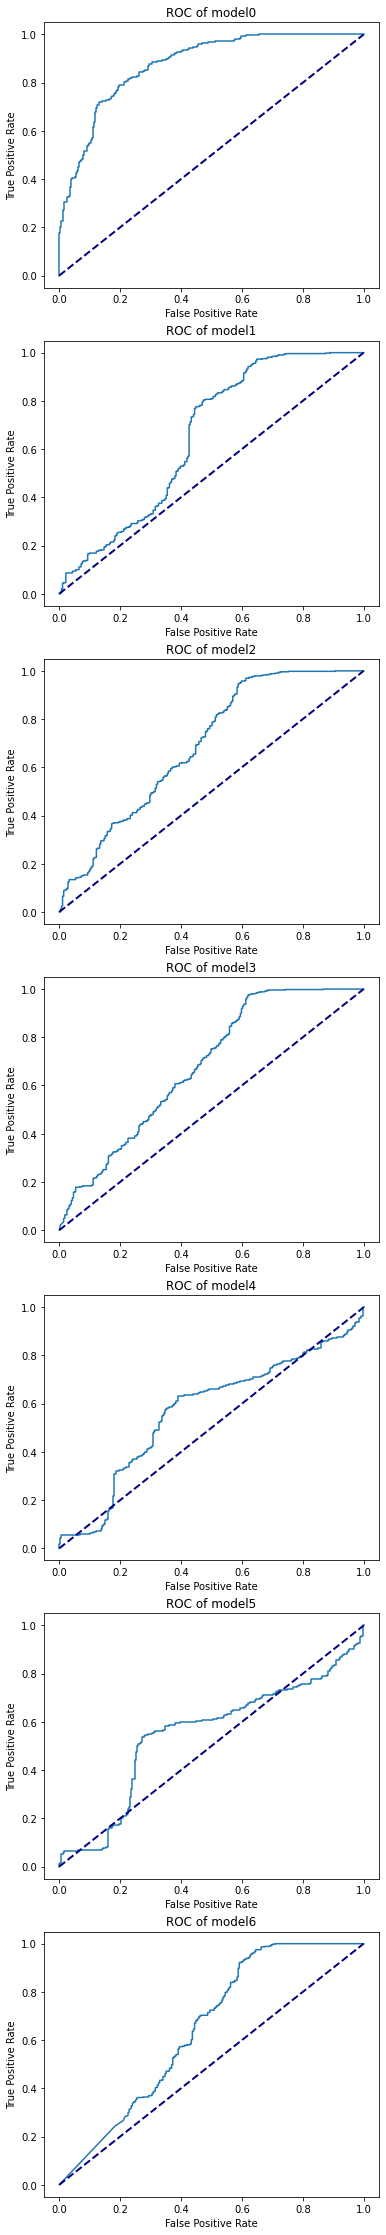

In [28]:
plt.figure(figsize=(6, 40))
all_fpr = []
all_tpr = []
all_thresholds = []
for i in range(7):
    plt.subplot(7, 1, i+1)
    fpr, tpr, thresholds = roc_curve(df["Label"], df[f"y_pred{i}"])
    plt.plot(fpr, tpr)
    plt.title(f"ROC of model{i}")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_thresholds.append(thresholds)

In [38]:
# Choosing Threshold based on optimal point at ROC curve
target = all_fpr[0]
t = [0.15, 0.45, 0.43, 0.43, 0.4, 0.3, 0.5]
for m in range(7):
    target = all_fpr[m]
    for i in range(len(target)):
        if target[i] > t[m]:
            break
    print(f"Model {m}", all_fpr[m][i-1], all_tpr[m][i-1], all_thresholds[m][i-1])

Model 0 0.13978494623655913 0.7222222222222222 0.5636191269468962
Model 1 0.44802867383512546 0.7758620689655172 0.6030460596084595
Model 2 0.4265232974910394 0.6360153256704981 0.6539053916931152
Model 3 0.4229390681003584 0.6264367816091954 0.5933043360710144
Model 4 0.3942652329749104 0.632183908045977 0.5247787833213806
Model 5 0.2903225806451613 0.5478927203065134 0.5930763483047485
Model 6 0.4946236559139785 0.7241379310344828 0.1266033947467804


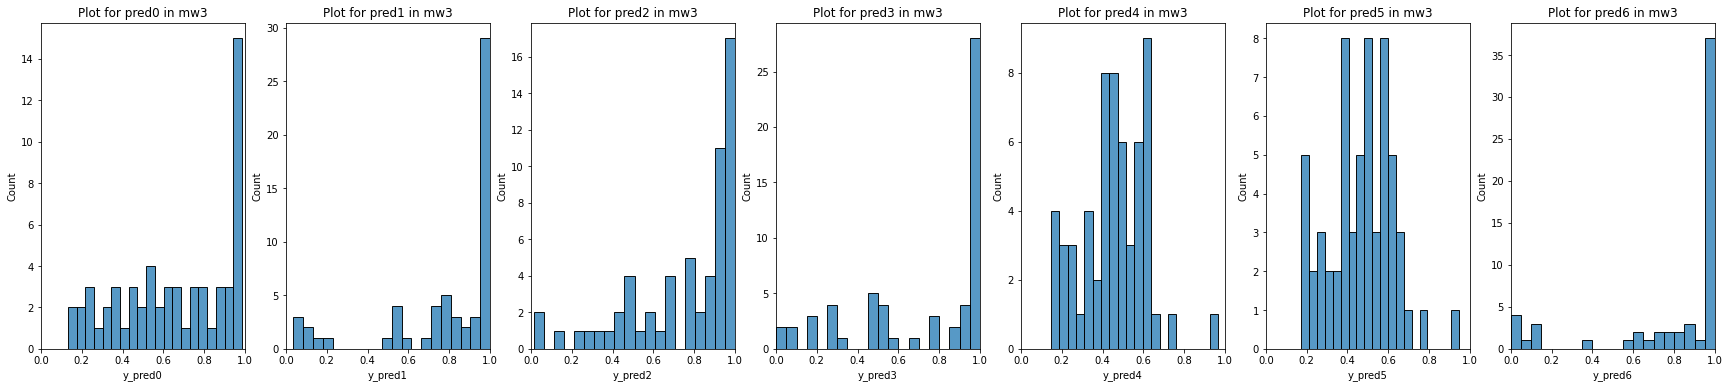

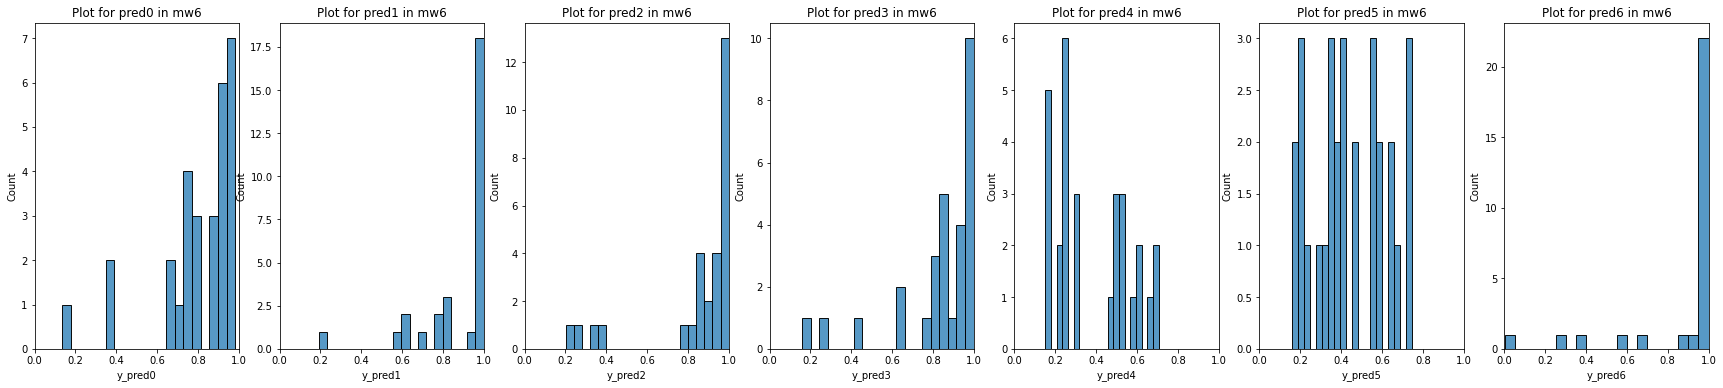

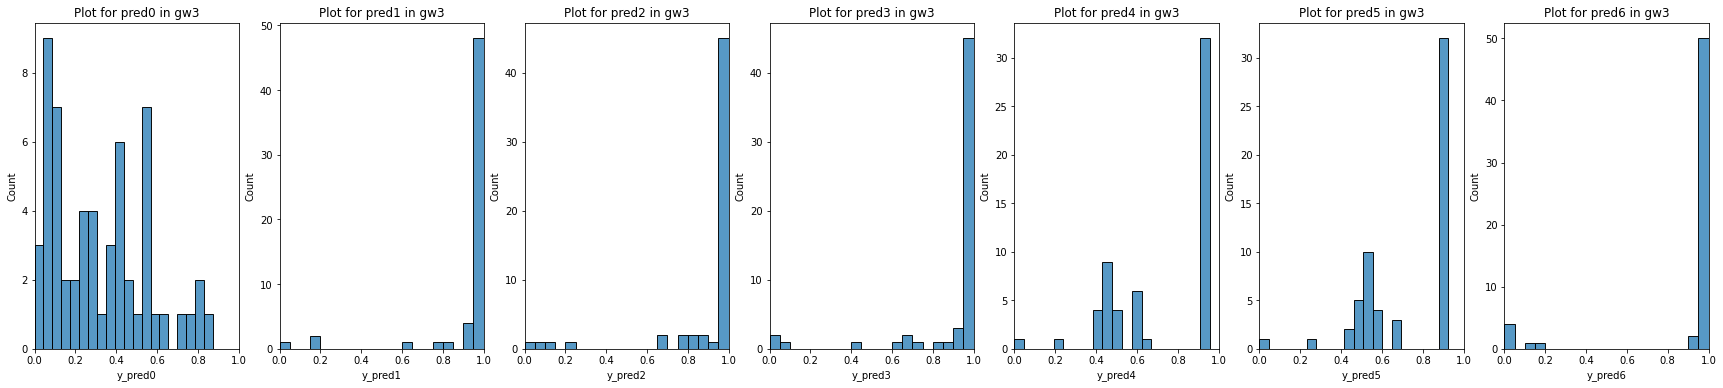

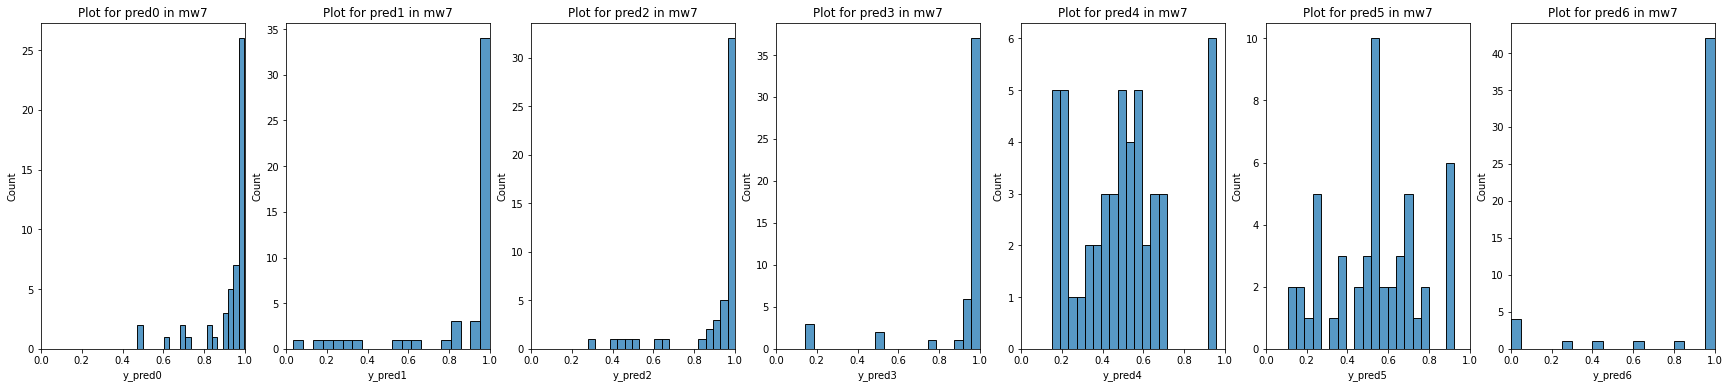

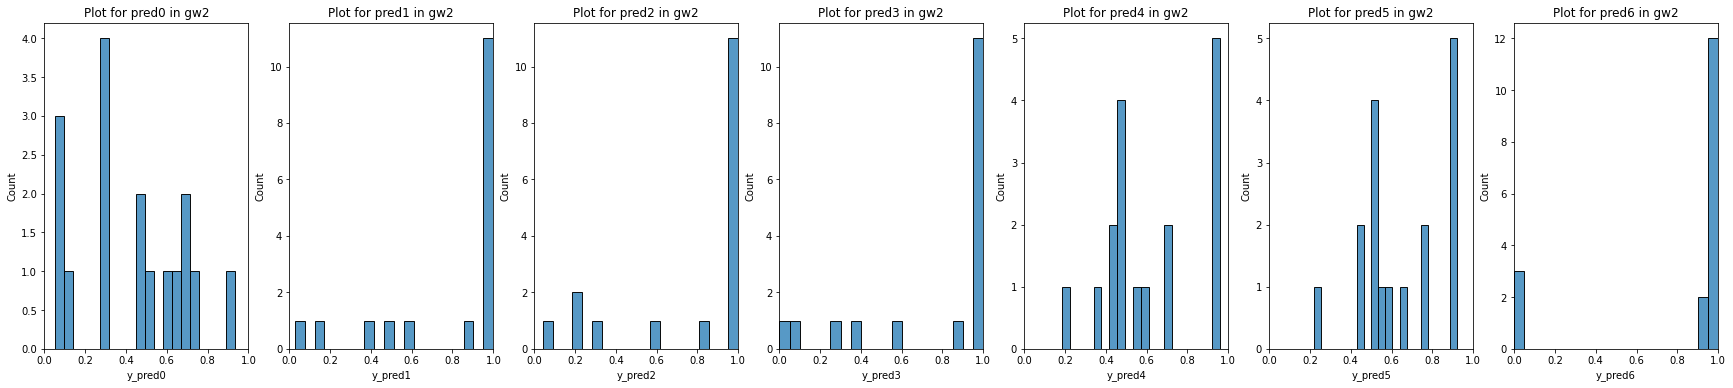

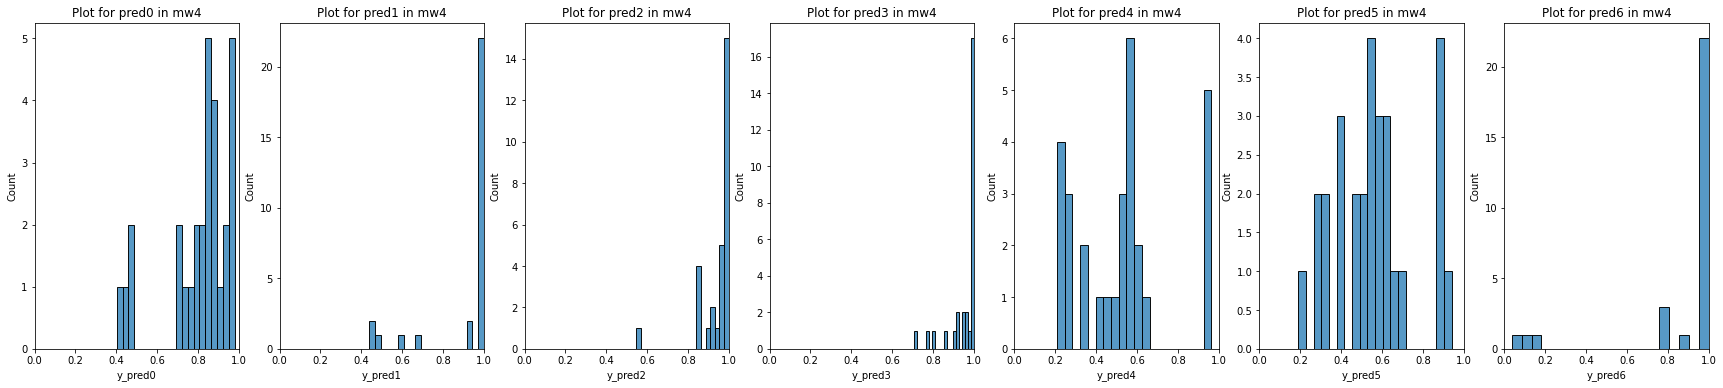

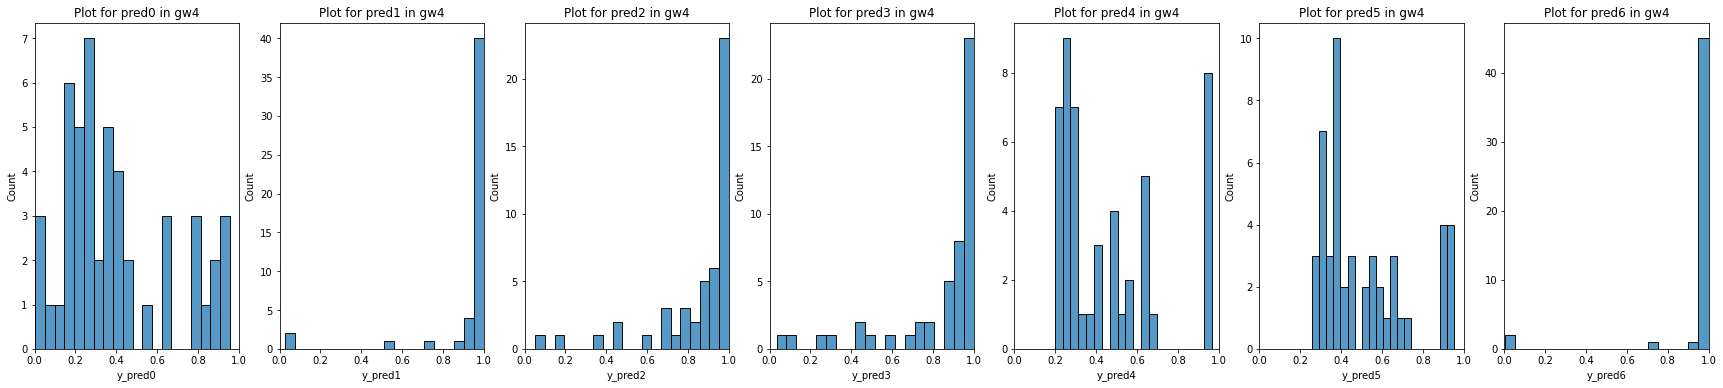

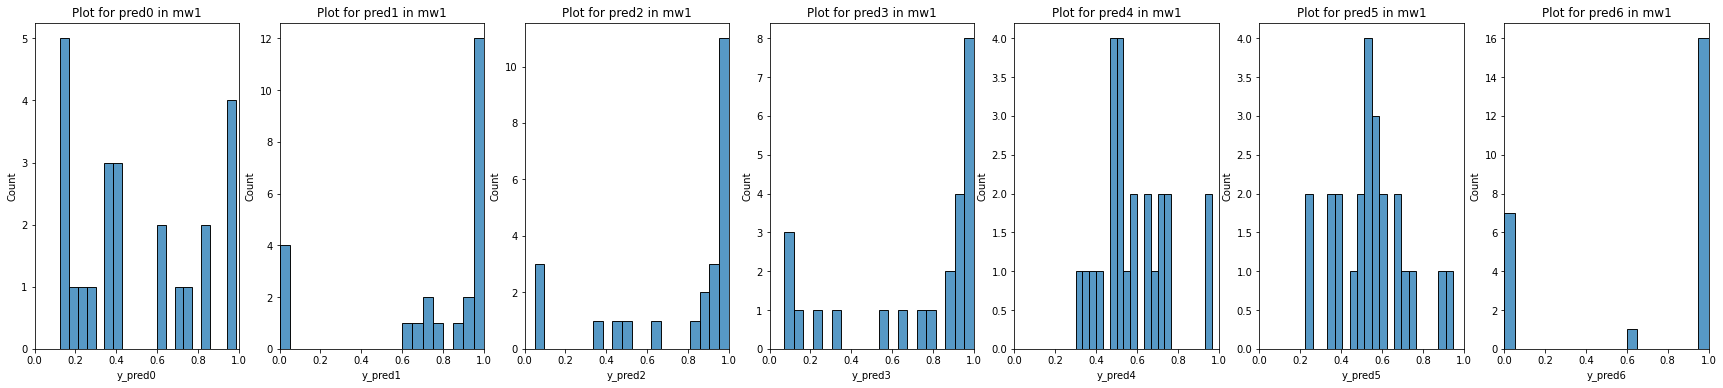

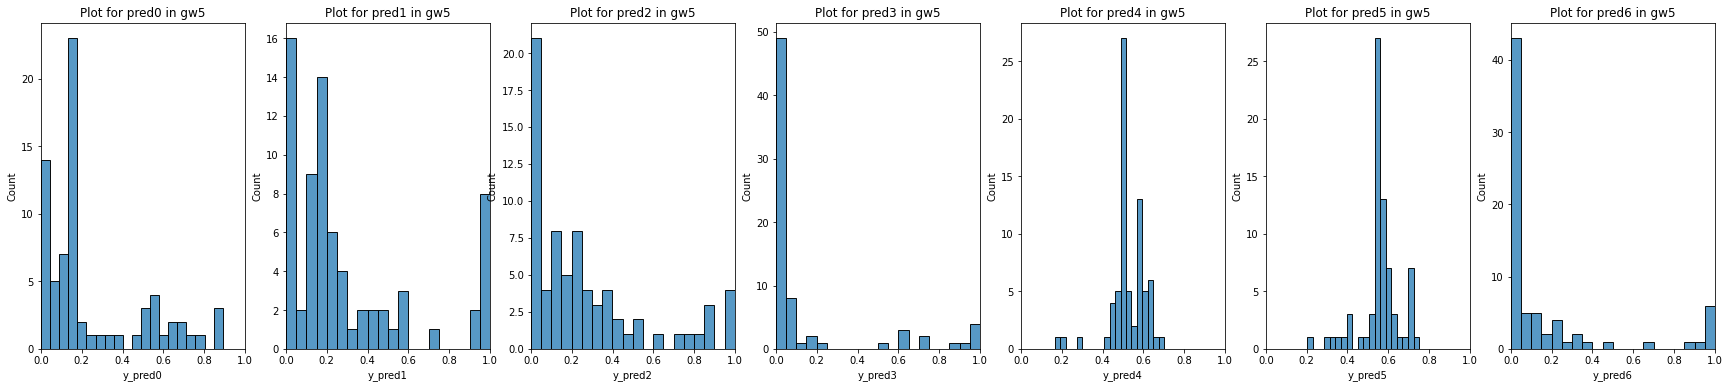

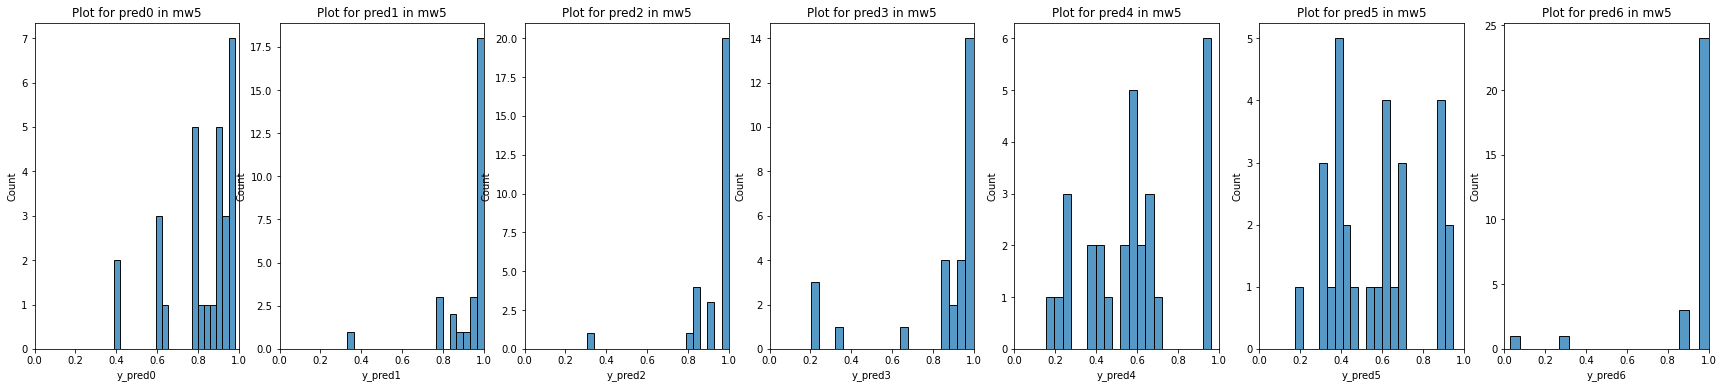

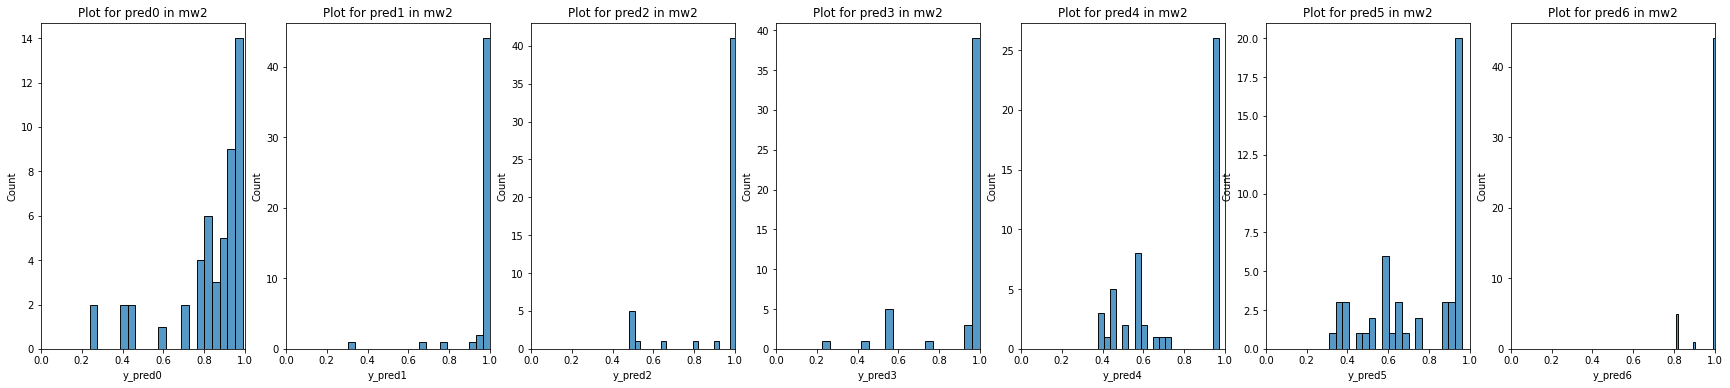

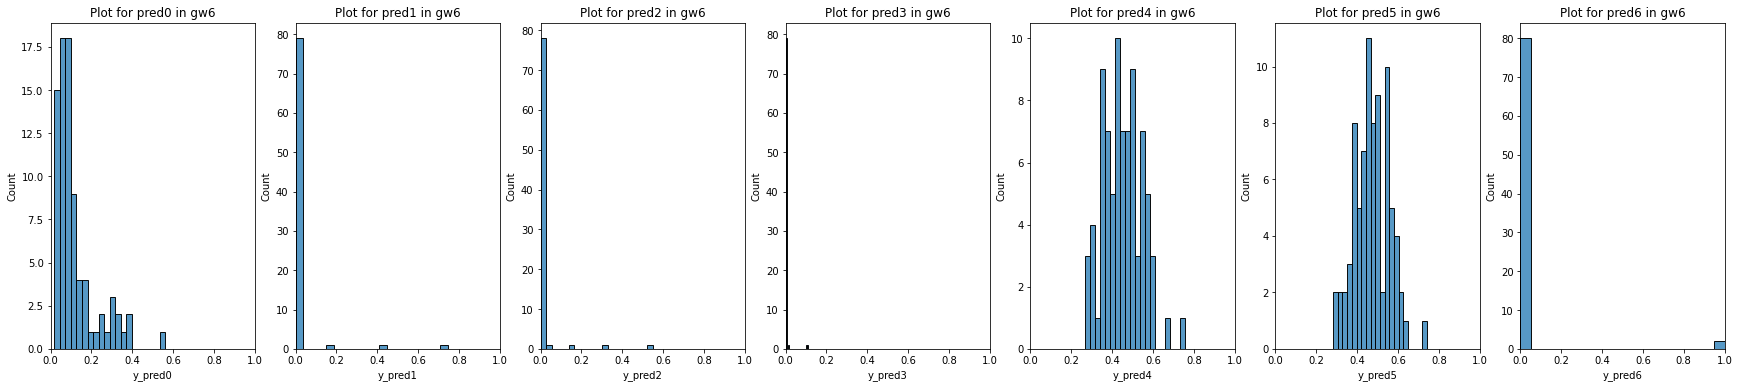

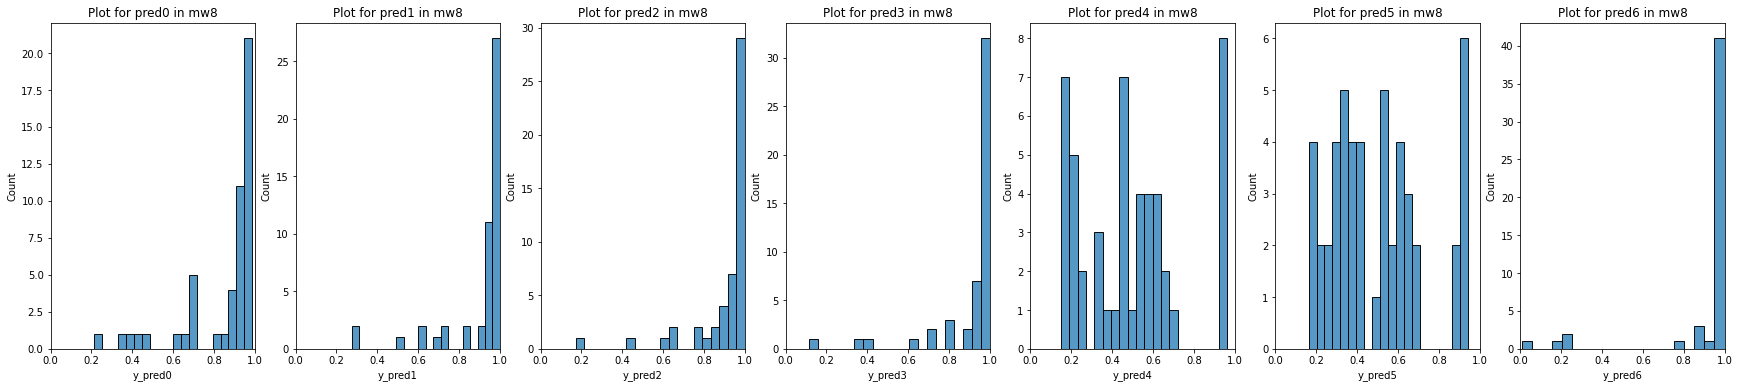

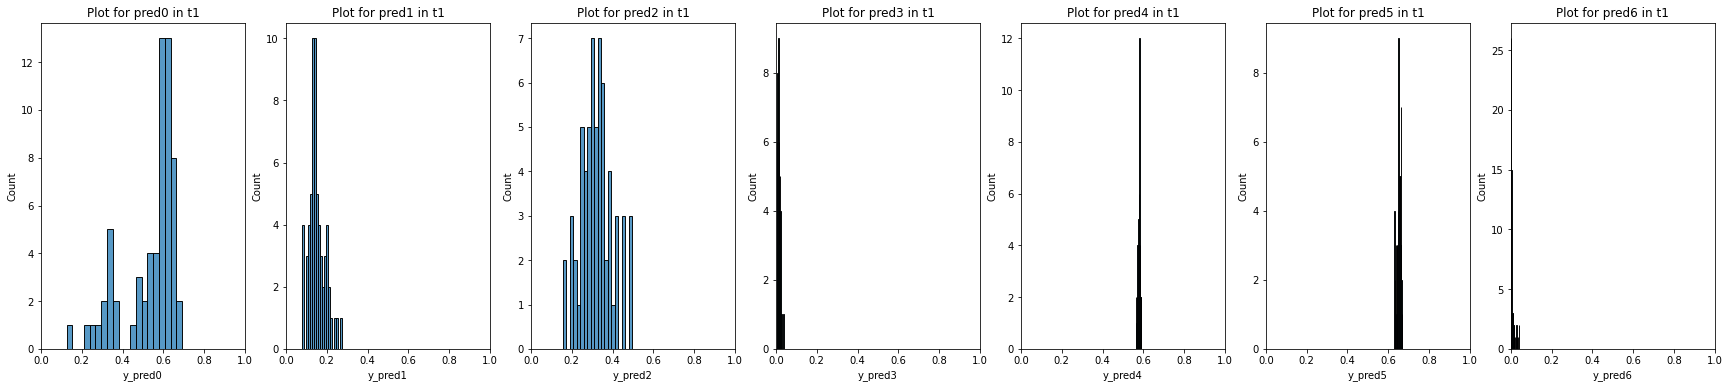

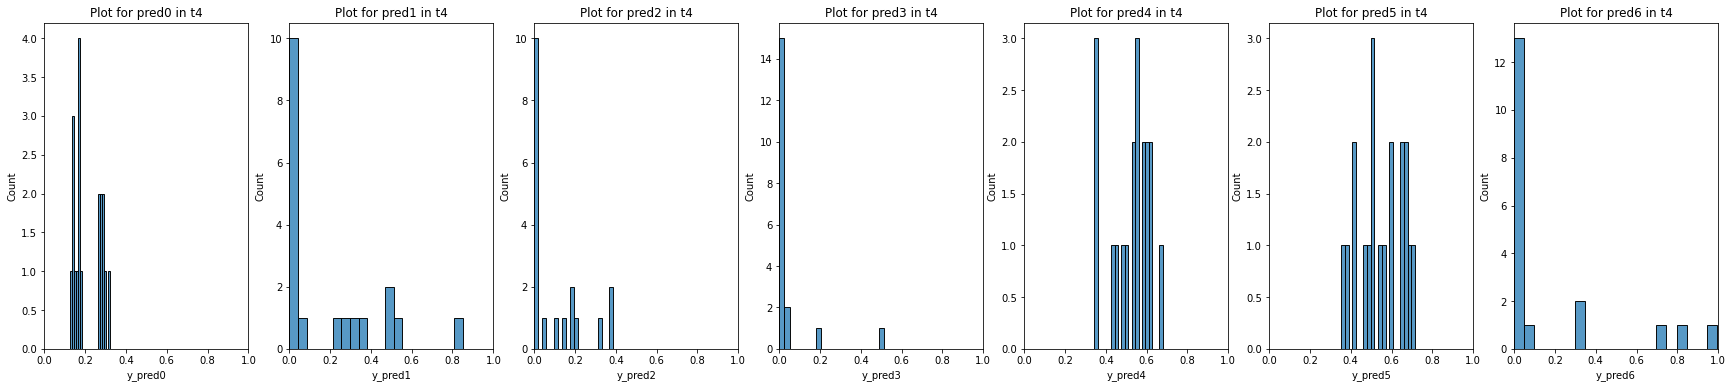

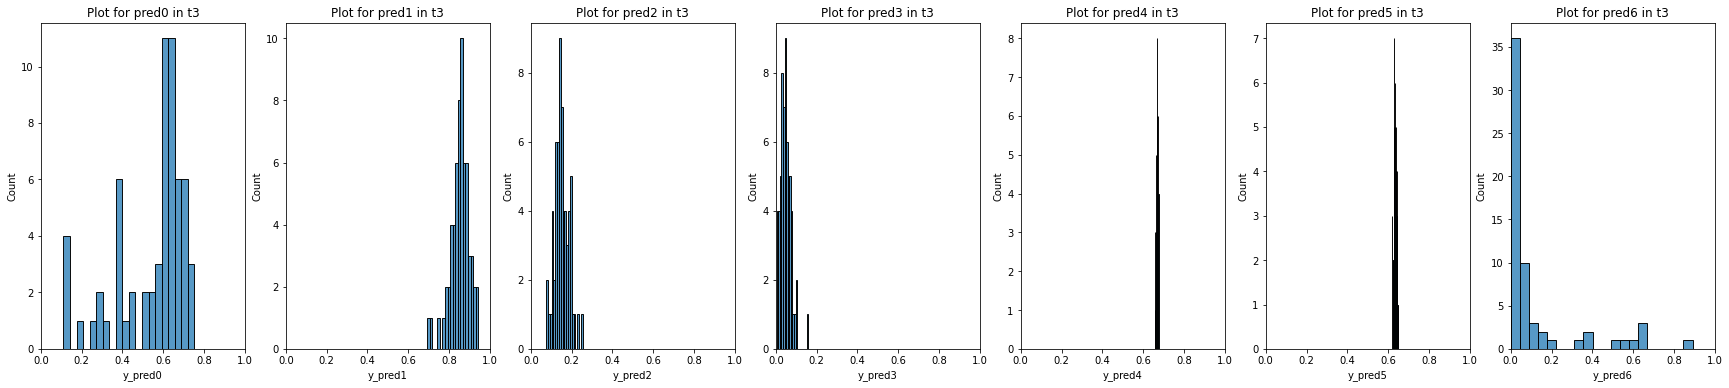

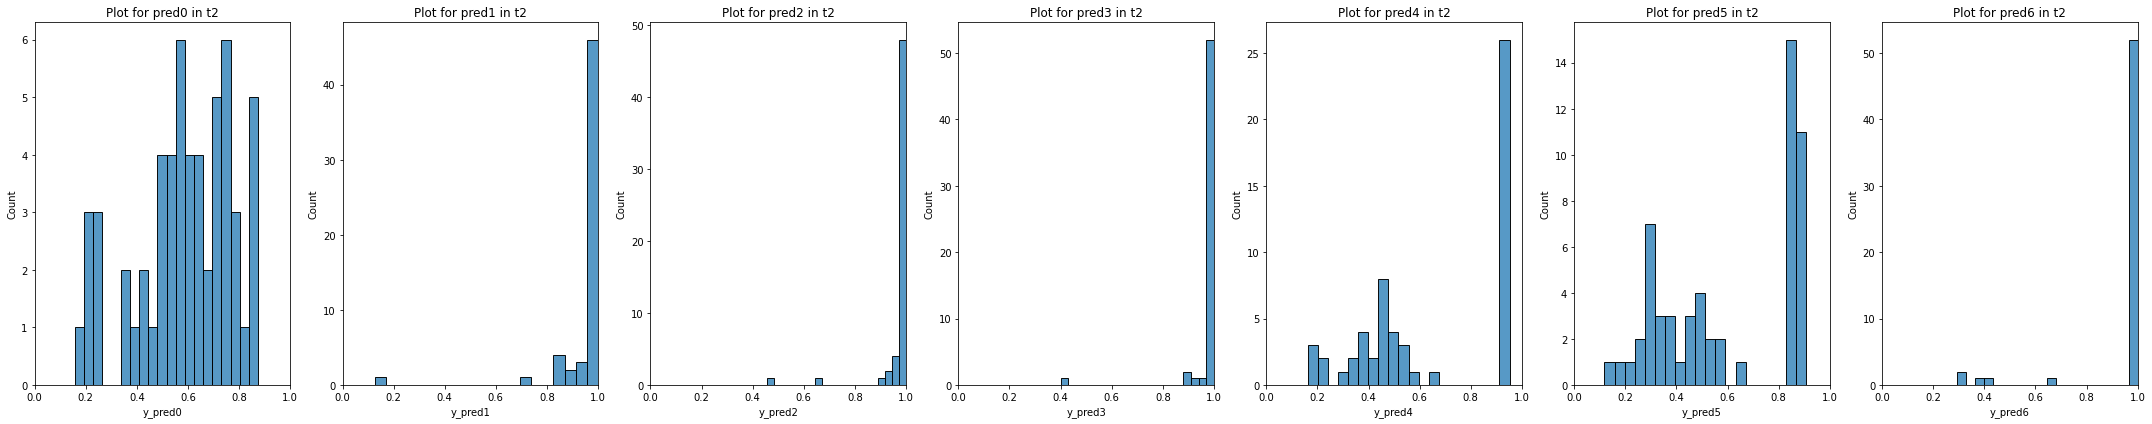

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
df_viz = df

datasets = df_viz['Dataset'].unique()
# datasets = ["mw1"]
for dataset in datasets:
    # print(dataset)
    plt.figure(figsize=(30, 6))
        
        # Data filtered by current dataset
    data_subset = df_viz[df_viz['Dataset'] == dataset]
    for i in range(7):
        plt.subplot(1, 7, i+1)
        sns.histplot(data=data_subset, x=f'y_pred{i}', palette='Set1', bins=20,  fill=True)
        plt.title(f'Plot for pred{i} in {dataset}')
        plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1

plt.tight_layout()
plt.show()

In [39]:
# Threshold by ROC
df['pred0_label'] = (df['y_pred0_1'] > 0.56).astype(int)
df['pred1_label'] = (df['y_pred1'] > 0.60).astype(int)
df['pred2_label'] = (df['y_pred2'] > 0.65).astype(int)
df['pred3_label'] = (df['y_pred3'] > 0.59).astype(int)
df['pred4_label'] = (df['y_pred4'] > 0.52).astype(int)
df['pred5_label'] = (df['y_pred5'] > 0.59).astype(int)
df['pred6_label'] = (df['y_pred6'] > 0.12).astype(int)

# df['pred0_label'] = (df['y_pred0_1'] > 0.24).astype(int)
# df['pred1_label'] = (df['y_pred1'] > 0.43).astype(int)
# df['pred2_label'] = (df['y_pred2'] > 0.35).astype(int)
# df['pred3_label'] = (df['y_pred3'] > 0.52).astype(int)
# df['pred4_label'] = (df['y_pred4'] > 0.55).astype(int)


df.head()

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6,y_pred0,pred0_label,pred1_label,pred2_label,pred3_label,pred4_label,pred5_label,pred6_label
0,mw3_0007,mw3,1,0.657261,0.342739,0.484929,0.286930,0.080173,0.146958,0.173287,0.685515,0.342739,0,0,0,0,0,0,1
1,mw3_0096,mw3,1,0.352234,0.647766,0.962446,0.932324,0.979886,0.660870,0.614219,1.000000,0.647766,1,1,1,1,1,1,1
2,mw3_0033,mw3,1,0.042992,0.957008,0.998051,0.968549,0.853065,0.221280,0.302193,1.000000,0.957008,1,1,1,1,0,0,1
3,mw3_0044,mw3,1,0.069854,0.930146,0.985843,0.999010,0.999969,0.502016,0.565494,0.943224,0.930146,1,1,1,1,0,0,1
4,mw3_0042,mw3,1,0.020122,0.979878,0.522511,0.503915,0.451619,0.576270,0.572180,0.127894,0.979878,1,0,0,0,1,0,1


# Expt Section

In [40]:
# df = pd.read_csv("all_rf+6models.csv", index_col=0)

In [56]:
def generate_pred_label(df):
    df['pred0_label'] = (df['y_pred0_1'] > 0.56).astype(int)
    df['pred1_label'] = (df['y_pred1'] > 0.60).astype(int)
    df['pred2_label'] = (df['y_pred2'] > 0.65).astype(int)
    df['pred3_label'] = (df['y_pred3'] > 0.59).astype(int)
    df['pred4_label'] = (df['y_pred4'] > 0.52).astype(int)
    df['pred5_label'] = (df['y_pred5'] > 0.59).astype(int)
    df['pred6_label'] = (df['y_pred6'] > 0.12).astype(int)
    return df
df = generate_pred_label(df)

In [82]:
def vote(rf, malconv0, malconv1, malconv2, attn0, attn1, attn2):
    malconv = malconv0 or malconv2
    attn = attn0 or attn2
    
    if (rf + malconv + attn) >= 2:
        return 1
    else:
        return 0
def threshold(rf, malconv0, malconv1, malconv2, attn0, attn1, attn2):
    attn = 0.7 * attn0 + 0.3 * attn2
    malconv = 0.5 * malconv0 + 0.5 * malconv2
    if attn > 0.6 :
        return 1
    elif malconv > 0.6:
        return 1
        # return rf_label
    else:
        return 0
df['threshold'] = df.apply(lambda x: threshold(x['y_pred0'], x['y_pred1'], x['y_pred2'], x['y_pred3'], x['y_pred4'], x['y_pred5'], x['y_pred6']), axis=1)
df['majority_vote'] = df.apply(lambda x: vote(x['pred0_label'], x['pred1_label'], x['pred2_label'], x['pred3_label'], x['pred4_label'], x['pred5_label'], x['pred6_label']), axis=1)

In [83]:
def calculate_accuracy(group):
    acc_pred0 = (group['pred0_label'] == group['Label']).mean()
    acc_pred1 = (group['pred1_label'] == group['Label']).mean()
    acc_pred2 = (group['pred2_label'] == group['Label']).mean()
    acc_pred3 = (group['pred3_label'] == group['Label']).mean()
    acc_pred4 = (group['pred4_label'] == group['Label']).mean()
    acc_pred5 = (group['pred5_label'] == group['Label']).mean()
    acc_pred6 = (group['pred6_label'] == group['Label']).mean()
    acc_vote = (group['majority_vote'] == group['Label']).mean()
    acc_thres = (group['threshold'] == group['Label']).mean()
    # vote = (group['pred0_label'] + group['pred1_label'] + group['pred2_label'] >= 2).astype(int).mean()
    # return pd.Series({'Accuracy_pred0': acc_pred0, 'Accuracy_pred1': acc_pred1, 'Accuracy_pred2': acc_pred2})
    return pd.Series({'Accuracy_pred0': acc_pred0, 'Accuracy_pred1': acc_pred1, 'Accuracy_pred2': acc_pred2, 'Accuracy_pred3': acc_pred3, 'Accuracy_pred4': acc_pred4, 'Accuracy_pred5': acc_pred5, 'Accuracy_pred6': acc_pred6, "Majority_vote":acc_vote, "threshold":acc_thres})
    # return pd.Series({'Accuracy_pred0': acc_pred0, 'Accuracy_pred1': acc_pred1, "Pipeline":acc_vote})


In [84]:
# Group by 'Dataset' and apply the accuracy function
accuracy_results = df.groupby('Dataset').apply(calculate_accuracy)
accuracy_results

,Accuracy_pred0,Accuracy_pred1,Accuracy_pred2,Accuracy_pred3,Accuracy_pred4,Accuracy_pred5,Accuracy_pred6,Majority_vote,threshold
Dataset,,,,,,,,,
gw2,0.647059,0.294118,0.294118,0.294118,0.470588,0.529412,0.176471,0.176471,0.117647
gw3,0.827586,0.051724,0.068966,0.068966,0.327586,0.362069,0.086207,0.086207,0.017241
gw4,0.734694,0.061224,0.122449,0.163265,0.673469,0.693878,0.040816,0.020408,0.061224
gw5,0.835616,0.849315,0.863014,0.849315,0.602740,0.726027,0.684932,0.794521,0.821918
gw6,0.987805,0.987805,1.000000,1.000000,0.780488,0.939024,0.975610,0.987805,0.963415
mw1,0.416667,0.833333,0.750000,0.708333,0.541667,0.291667,0.708333,0.791667,0.750000
mw2,0.880000,0.980000,0.860000,0.860000,0.780000,0.760000,1.000000,0.980000,1.000000
mw3,0.616667,0.800000,0.716667,0.650000,0.350000,0.250000,0.916667,0.900000,0.850000
mw4,0.862069,0.862069,0.965517,1.000000,0.586207,0.379310,0.931034,1.000000,1.000000
